In [1]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, io_shape):
        super(MultiSplit, self).__init__()
        n_filters = [32, 64]
        size = int( io_shape[0] // (n_splits**(1/2)) )  # W = H
        self.encoder = self._create_encoder(latent_dim//n_splits, (size, size,1), n_filters)
        self.input_reshaper = utils.Reshaper((n_splits, size, size, 1), (size, size,1))
        self.latent_reshaper = utils.Reshaper([latent_dim//n_splits], [latent_dim])
        self.classifier = self._create_classifier(latent_dim)
#         self.decoder = self._create_decoder(latent_dim, io_shape, n_filters)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            z = self.encode(x)
            y_pred = self.classify(z)
#             y_pred = self.decode(z)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        z = self.encode(x, training=False)
        y_pred = self.classify(z ,training=False)
#         y_pred = self.decode(z ,training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Flatten(),
            Dense(units=latent_dim)
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(io_shape[0]//4 * io_shape[1]//4 * n_filters[0]),  # factor 4 due to conv.
            Reshape((io_shape[0]//4, io_shape[1]//4, n_filters[0])),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(10, activation='softmax')
        ])

In [2]:
import keras
import numpy as np

n_splits = 4
io_shape = (28,28,1)
size = int(io_shape[0] // (n_splits**(1/2)))
latent_dim = 16

model = MultiSplit(n_splits, latent_dim, io_shape)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_split = np.array([utils.split(x, size, size) for x in x_train], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_split = np.array([utils.split(x, size, size) for x in x_test], dtype='float32')
y_test = keras.utils.to_categorical(y_test)

Epoch 1/20
1875/1875 [==============================] - 3s 1ms/step - loss: 1.5168 - acc: 0.5306 - val_loss: 1.0911 - val_acc: 0.6711
Epoch 2/20
1875/1875 [==============================] - 3s 1ms/step - loss: 1.0286 - acc: 0.6822 - val_loss: 0.9368 - val_acc: 0.7075
Epoch 3/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.9350 - acc: 0.7063 - val_loss: 0.8735 - val_acc: 0.7212
Epoch 4/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.8905 - acc: 0.7183 - val_loss: 0.8402 - val_acc: 0.7304
Epoch 5/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.8646 - acc: 0.7245 - val_loss: 0.8182 - val_acc: 0.7376
Epoch 6/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.8471 - acc: 0.7300 - val_loss: 0.8027 - val_acc: 0.7408
Epoch 7/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.8348 - acc: 0.7335 - val_loss: 0.7912 - val_acc: 0.7443
Epoch 8/20
1875/1875 [==============================] - 2s 1ms

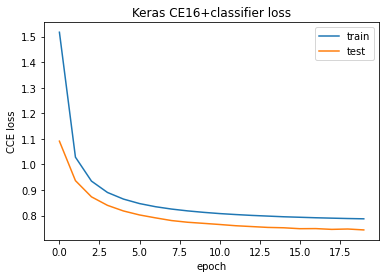

In [3]:
model.encoder.load_weights('../weights/18_CE4_scrambled_epoch25.h5')
# model.encoder.load_weights('../weights/18_CE4_ordered_epoch25.h5')
for layer in model.encoder.layers:
    layer.trainable = False
    
model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam') # COMPILE AFTER WEIGHTS LOADED
# model.compile(loss='mse', optimizer='adam') # COMPILE AFTER WEIGHTS LOADED

# history = model.fit(x_train_split, x_train, validation_data=(x_test_split, x_test), epochs=25, batch_size=32)
history = model.fit(x_train_split, y_train, validation_data=(x_test_split, y_test), epochs=20, batch_size=32)

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Keras CE16+classifier loss')
plt.ylabel('CCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Epoch 1/20
1875/1875 [==============================] - 3s 1ms/step - loss: 1.0879 - acc: 0.6925 - val_loss: 0.5310 - val_acc: 0.8795
Epoch 2/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4668 - acc: 0.8803 - val_loss: 0.3998 - val_acc: 0.8949
Epoch 3/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3931 - acc: 0.8917 - val_loss: 0.3600 - val_acc: 0.9014
Epoch 4/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3665 - acc: 0.8952 - val_loss: 0.3424 - val_acc: 0.9050
Epoch 5/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3537 - acc: 0.8980 - val_loss: 0.3331 - val_acc: 0.9073
Epoch 6/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3462 - acc: 0.8988 - val_loss: 0.3276 - val_acc: 0.9068
Epoch 7/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3414 - acc: 0.8999 - val_loss: 0.3242 - val_acc: 0.9074
Epoch 8/20
1875/1875 [==============================] - 2s 1ms

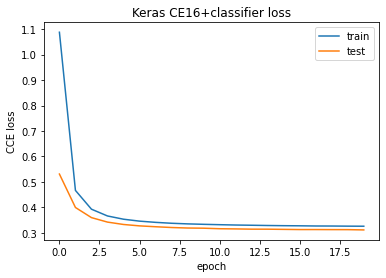

In [3]:
# model.encoder.load_weights('../weights/18_CE4_scrambled_epoch25.h5')
model.encoder.load_weights('../weights/18_CE4_ordered_epoch25.h5')
for layer in model.encoder.layers:
    layer.trainable = False
    
model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam') # COMPILE AFTER WEIGHTS LOADED
# model.compile(loss='mse', optimizer='adam') # COMPILE AFTER WEIGHTS LOADED

# history = model.fit(x_train_split, x_train, validation_data=(x_test_split, x_test), epochs=25, batch_size=32)
history = model.fit(x_train_split, y_train, validation_data=(x_test_split, y_test), epochs=20, batch_size=32)

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Keras CE16+classifier loss')
plt.ylabel('CCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()